Compare consumption profile before and consumption profile after. See clustering of consumption in 2019, 2018, 2020. Consumption profile. Need to find pattern which make the transformation from temporal representation to space representation possible. Temporal sequence clustering(check). How to identify temporal patterns? 

In [232]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# For the dataset without nulled consumers

In [233]:
df = pd.read_csv('data/dataset_without_nulled.csv', low_memory=False).drop(columns={'Installation_zone'})
df.head(5)

,Year,Month,Consumer_number,Consumer_type,Consumption
0,2013,1,21018,1,0
1,2013,1,36690,2,5
2,2013,1,17940,1,6
3,2013,1,14273,1,1
4,2013,1,5,1,13


In [166]:
monthes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
years = [2013, 2014, 2016, 2017, 2018, 2019, 2020]

In [167]:
df_1 = df[df['Year'] == 2019].drop(columns={'Year'})
df_1 = df_1.drop_duplicates().fillna(0)
df_1= df_1.groupby(['Consumer_number', 'Month'], as_index = False).sum()
df_1 = df_1.drop(df_1.index[0])
df_1.head(5)

,Consumer_number,Month,Consumer_type,Consumption
1,1,5,3,208
2,1,7,3,219
3,1,8,3,308
4,5,1,1,8
5,5,5,1,8


In [168]:
df_pivot = df_1.pivot(index = 'Consumer_number', columns = 'Month', values = 'Consumption').fillna(0)
print("len with nulled:", len(df_pivot))
df_pivot = df_pivot.rename_axis(None,axis=1).set_axis(monthes, inplace=False, axis=1).reset_index()
df_pivot = df_pivot.loc[~df_pivot[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].apply(lambda row: (row==0).all(), axis=1)]
df_pivot.head(5)
print("len without nullded:", len(df_pivot))

len with nulled: 18842
len without nullded: 16519


In [169]:
x = df_pivot.loc[:, monthes].values
print('x shape:', x.shape)
y = df_pivot.loc[:,['Consumer_number']].values
print('y shape:', y.shape)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['x', 'y'])

x shape: (16519, 12)
y shape: (16519, 1)


In [252]:
principalDf.head()

,x,y
0,4.286582,14.615340
1,-0.219893,0.289303
2,-0.138007,-0.081128
3,-0.020668,0.266720
4,0.106276,-0.181536


In [170]:
resultDf = pd.merge(principalDf, df_pivot['Consumer_number'], left_index=True, right_index=True)
print(resultDf.head(5))

          x          y  Consumer_number
0  4.286582  14.615340                1
1 -0.219893   0.289303                5
2 -0.138007  -0.081128               11
3 -0.020668   0.266720               15
4  0.106276  -0.181536               16



Clusters discovered: 20


<AxesSubplot:xlabel='x', ylabel='y'>

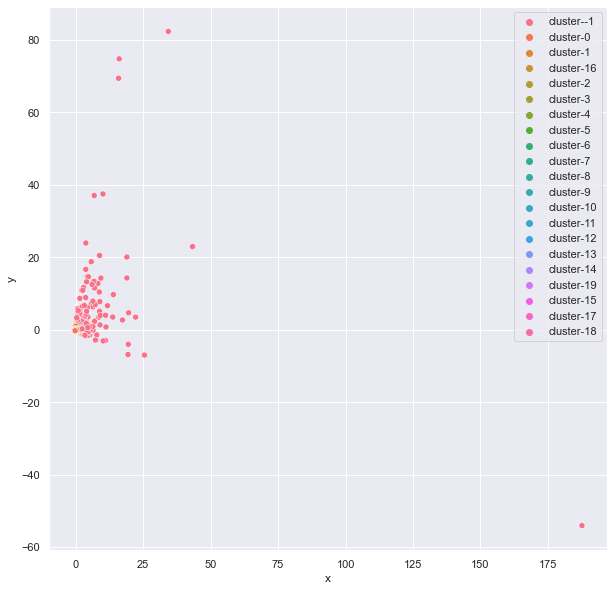

In [254]:
clf = DBSCAN(eps=0.1, min_samples=3).fit(principalDf)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(principalDf['x'], principalDf['y'], hue=["cluster-{}".format(x) for x in labels])

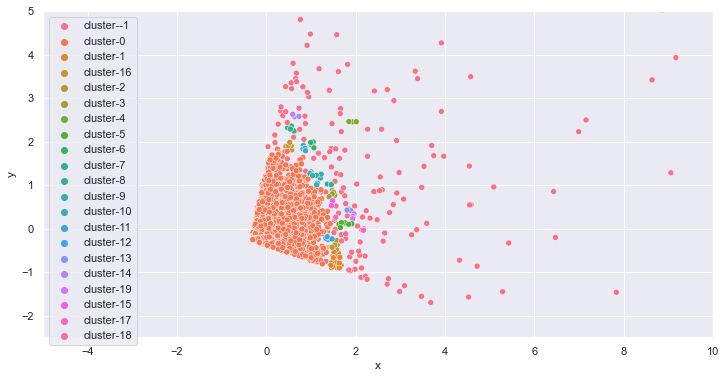

In [255]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(principalDf['x'], principalDf['y'], hue=["cluster-{}".format(x) for x in labels])
plt.xlim([-5, 10])
plt.ylim([-2.5, 5])
plt.savefig("charts/dbscan/dbscan_pca_without_nulled.png", bbox_inches='tight')
plt.show()

In [186]:
label = pd.DataFrame({'Label': labels})
df_2 = resultDf.join(label).drop(columns={'x', 'y'})
df_2.head(5)

,Consumer_number,Label
0,1,-1
1,5,0
2,11,0
3,15,0
4,16,0


In [174]:
tipo_de_cons = df.drop(columns={'Month'})
tipo_de_cons = tipo_de_cons[tipo_de_cons['Year'] == 2019].drop(columns={'Year'})
# tipo_de_cons = tipo_de_cons.groupby(columns=['Consumer_number', 'Consumer_type'])
tipo_de_cons = tipo_de_cons.groupby(['Consumer_number', 'Consumer_type'], as_index=False).sum()
tipo_de_cons.head(5)

,Consumer_number,Consumer_type,Consumption
0,1,3,766
1,5,1,24
2,11,1,16
3,15,2,22
4,16,1,31


In [265]:
df_2 = pd.merge(df_2, tipo_de_cons, on="Consumer_number")
df_2 = df_2.drop(columns={'Consumer_number', 'Consumption'})
df_2['Count'] = df_2['Consumer_type']
df_2.head()
len(df_2)

14668

In [276]:
df_final = df_2.groupby(['Label', 'Consumer_type'], as_index=False).agg({'Count':'count'})
print(df_final)
# print(len(df_final))

    Label  Consumer_type  Count
0      -1              1    116
1      -1              2     17
2      -1              3      1
3      -1              4      1
4      -1              9     34
5      -1             14      1
6      -1             19      3
7       0              1   9139
8       0              2    810
9       0              3     35
10      0              4     82
11      0              5     52
12      0              6      3
13      0              7     79
14      0              9   3689
15      0             10     38
16      0             11      6
17      0             12     56
18      0             14     39
19      0             18     18
20      0             19    360
21      0             20      7
22      1              1      9
23      1              2      3
24      1              9      4
25      1             19      1
26      2              1      2
27      2              9      2
28      3              1      3
29      4              1      2
30      

In [267]:
df_final['Consumer_type'].unique()

array([ 1,  2,  3,  4,  9, 14, 19,  5,  6,  7, 10, 11, 12, 18, 20],
      dtype=int64)

In [282]:
df_final.loc[df_final["Label"] == -1, "Label"] = 20
df_final.head()


,Label,Consumer_type,Count
0,20,1,116
1,20,2,17
2,20,3,1
3,20,4,1
4,20,9,34


,Consumer_type,Name
0,1,DOMÉSTICO
1,2,COM/INDUSTRIAL/OBRAS
2,3,UTIL.PUBLICA
3,4,OBRAS
4,5,ESTADO
5,6,IGREJAS
6,7,EXP.A.RURAL
7,9,RURAL DOMÉSTICO
8,10,RURAL/ESTADO
9,11,FAM.NUMEROSAS


In [311]:
df_final = pd.merge(df_final, cons_tipos, on="Consumer_type").drop(columns={'Consumer_type'}).rename(columns={'Name':'Consumer_type'})
df_final

,Label,Count,Consumer_type
0,20,116,DOMÉSTICO
1,0,9139,DOMÉSTICO
2,1,9,DOMÉSTICO
3,2,2,DOMÉSTICO
4,3,3,DOMÉSTICO
5,4,2,DOMÉSTICO
6,5,5,DOMÉSTICO
7,6,4,DOMÉSTICO
8,7,3,DOMÉSTICO
9,8,1,DOMÉSTICO


In [357]:
df_pivot = pd.pivot(df_final, values='Count', index=['Label'],
                    columns=['Consumer_type']).fillna(0)
df_pivot = df_pivot.rename_axis(None,axis=1).reset_index()

In [381]:
# df_pivot_1 = df_pivot.loc[(df_pivot['Label'] == 0)  | (df_pivot.Label == 20)]
# df_pivot_2 = df_pivot[df_pivot.Label != 0]
df_pivot_3 = df_pivot.loc[ (df_pivot.Label == 20)]

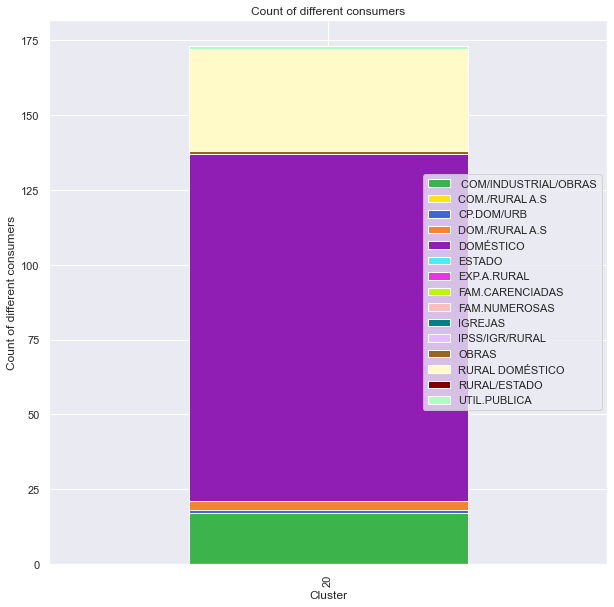

In [383]:
df_pivot_3.plot(figsize=(10,10), x = 'Label', kind='bar', stacked=True, color=['#3cb44b', '#ffe119', '#4363d8', 
                                                                     '#f58231', '#911eb4', '#46f0f0', '#f032e6',  '#bcf60c', 
                                                                     '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                                                                     '#800000', '#aaffc3', '#ffd8b1', 
                                                                     '#000075', '#808080'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different consumers')
 
# title of plot
plt.title('Count of different consumers')
plt.savefig("charts/dbscan/dbscan_pca_cluster_20_profile.png", bbox_inches='tight')
plt.show()

In [369]:
df_pivot_2 = df_pivot_2[df_pivot_2.Label != 20]
df_pivot_2

,Label,COM/INDUSTRIAL/OBRAS,COM./RURAL A.S,CP.DOM/URB,DOM./RURAL A.S,DOMÉSTICO,ESTADO,EXP.A.RURAL,FAM.CARENCIADAS,FAM.NUMEROSAS,IGREJAS,IPSS/IGR/RURAL,OBRAS,RURAL DOMÉSTICO,RURAL/ESTADO,UTIL.PUBLICA
1,1,3.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,9,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,10,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


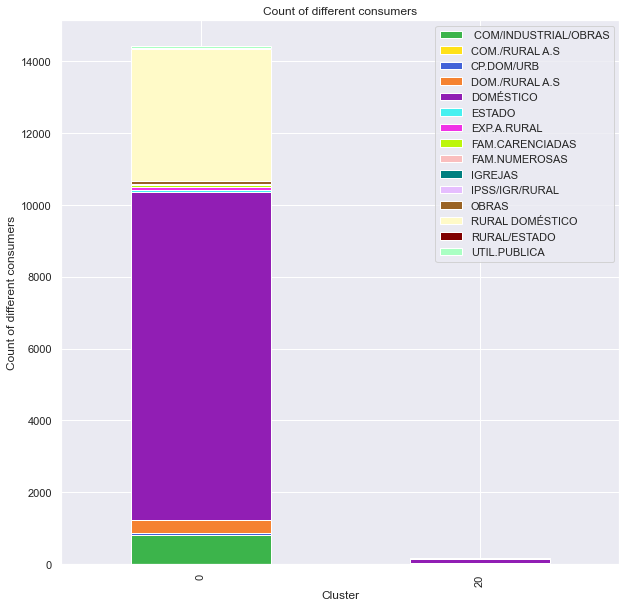

In [384]:
df_pivot_1.plot(figsize=(10,10), x = 'Label', kind='bar', stacked=True, color=['#3cb44b', '#ffe119', '#4363d8', 
                                                                     '#f58231', '#911eb4', '#46f0f0', '#f032e6',  '#bcf60c', 
                                                                     '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                                                                     '#800000', '#aaffc3', '#ffd8b1', 
                                                                     '#000075', '#808080'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different consumers')
 
# title of plot
plt.title('Count of different consumers')
plt.savefig("charts/dbscan/dbscan_pca_cluster0_profile.png", bbox_inches='tight')
plt.show()

In [330]:
df_pivot_2

,Label,COM/INDUSTRIAL/OBRAS,COM./RURAL A.S,CP.DOM/URB,DOM./RURAL A.S,DOMÉSTICO,ESTADO,EXP.A.RURAL,FAM.CARENCIADAS,FAM.NUMEROSAS,IGREJAS,IPSS/IGR/RURAL,OBRAS,RURAL DOMÉSTICO,RURAL/ESTADO,UTIL.PUBLICA
1,1,3.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,9,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,10,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


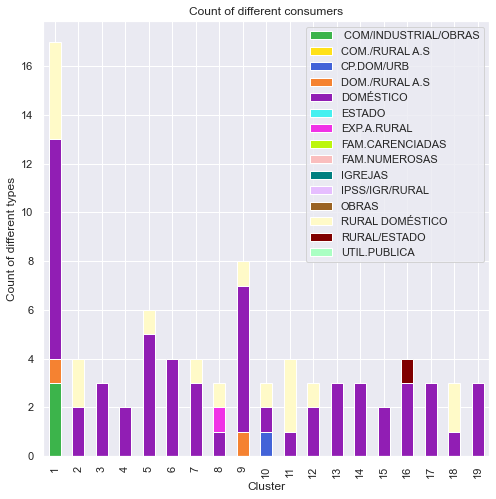

In [370]:
df_pivot_2.plot.bar(figsize=(8,8), x = 'Label', stacked=True, color=['#3cb44b', '#ffe119', '#4363d8', 
                                                                     '#f58231', '#911eb4', '#46f0f0', '#f032e6',  '#bcf60c', 
                                                                     '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                                                                     '#800000', '#aaffc3', '#ffd8b1', 
                                                                     '#000075', '#808080'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different types')
 
# title of plot
plt.title('Count of different consumers')
plt.savefig("charts/dbscan/dbscan_pca_profiles.png", bbox_inches='tight', sharex=False)
plt.show()

# For the dataset WITH nulled consumers

In [234]:
df_null = pd.read_csv('data/dataset.csv', low_memory=False).drop(columns={'Installation_zone'})
df_null.head(5)

,Year,Month,Consumer_number,Consumer_type,Consumption
0,2013,1,21018,1,0
1,2013,1,36690,2,5
2,2013,1,17940,1,6
3,2013,1,14273,1,1
4,2013,1,5,1,13


In [235]:
print(len(df_null))

2171458


In [236]:
df_null_1 = df_null[df_null['Year'] == 2019].drop(columns={'Year'})
df_null_1  = df_null_1.drop_duplicates().fillna(0)
df_null_1 = df_null_1.groupby(['Consumer_number', 'Month'], as_index = False).sum()
df_null_1 = df_null_1.drop(df_null_1.index[0])
df_null_1.head(5)

,Consumer_number,Month,Consumer_type,Consumption
1,1,2,3,330
2,1,3,3,331
3,1,4,3,31
4,1,5,3,208
5,1,6,3,231


In [237]:
df_null_pivot = df_null_1.pivot(index = 'Consumer_number', columns = 'Month', values = 'Consumption')
df_null_pivot = df_null_pivot.fillna(0)
df_null_pivot = df_null_pivot.rename_axis(None,axis=1).set_axis(monthes, inplace=False, axis=1).reset_index()
df_null_pivot.head(5)

,Consumer_number,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0.0,330.0,331.0,31.0,208.0,231.0,219.0,308.0,259.0,224.0,268.0,131.0
1,5,8.0,0.0,4.0,22.0,8.0,9.0,8.0,9.0,8.0,8.0,9.0,7.0
2,11,2.0,13.0,8.0,0.0,4.0,2.0,3.0,12.0,8.0,2.0,5.0,0.0
3,15,6.0,19.0,13.0,0.0,7.0,4.0,6.0,5.0,0.0,3.0,12.0,8.0
4,16,0.0,0.0,0.0,0.0,30.0,0.0,15.0,8.0,12.0,0.0,4.0,0.0


In [238]:
len(df_null_pivot)

27801

In [239]:
df_final = df_null_pivot.loc[~df_null_pivot[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].apply(lambda row: (row==0).all(), axis=1)]
df_final.head(5)
print(len(df_final))

24034


In [240]:
x_1 = df_final.loc[:, monthes].values
print('x shape:', x.shape)
y_1 = df_final.loc[:,['Consumer_number']].values
print('y shape:', y.shape)
x_1 = StandardScaler().fit_transform(x_1)
pca = PCA(n_components=2)
principalComponents_1 = pca.fit_transform(x_1)
principalDf_1 = pd.DataFrame(data = principalComponents_1
             , columns = ['x', 'y'])
principalDf_1.head(5)

x shape: (16519, 12)
y shape: (16519, 1)


,x,y
0,18.115302,-2.184584
1,0.203037,-0.062384
2,-0.142351,-0.033060
3,0.035644,0.030123
4,-0.029886,-0.167562



Clusters discovered: 10


<AxesSubplot:xlabel='x', ylabel='y'>

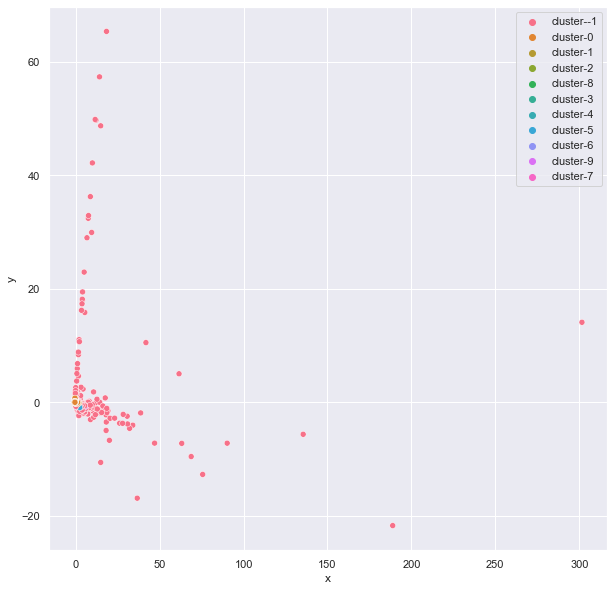

In [241]:
clf = DBSCAN(eps=0.1, min_samples=3).fit(principalDf_1)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(principalDf_1['x'], principalDf_1['y'], hue=["cluster-{}".format(x) for x in labels])

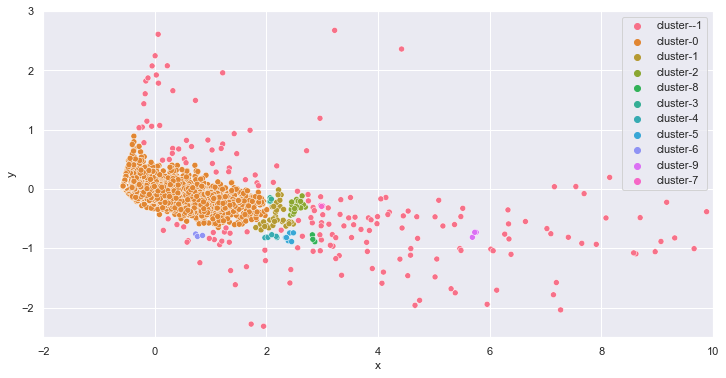

In [242]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(principalDf_1['x'], principalDf_1['y'], hue=["cluster-{}".format(x) for x in labels])
plt.xlim([-2, 10])
plt.ylim([-2.5, 3])
plt.show()

In [243]:
final = pd. merge(principalDf_1, df_null_pivot['Consumer_number'], left_index=True, right_index=True)
len(final)

24034

In [244]:
label = pd.DataFrame({'Label': labels})
resultDf_1 = final.join(label).drop(columns={'x', 'y'})
resultDf_1.head(5)

,Consumer_number,Label
0,1,-1
1,5,0
2,11,0
3,15,0
4,16,0


In [245]:
resultDf = pd.merge(resultDf_1, tipo_de_cons, on="Consumer_number")
resultDf = resultDf.drop(columns={'Consumer_number', 'Consumption'})
resultDf['Count'] = resultDf['Consumer_type']
print(resultDf.head(5))
len(resultDf)

   Label  Consumer_type  Count
0     -1              3      3
1      0              1      1
2      0              1      1
3      0              2      2
4      0              1      1


15731

In [246]:
resultDf = resultDf.groupby(['Label', 'Consumer_type'], as_index=False).agg({'Count':'count'})
print(len(resultDf))
resultDf_pivot = resultDf.pivot(values = 'Count', index=['Label'], columns = 'Consumer_type' ).reset_index().fillna(0)
resultDf_pivot = resultDf_pivot.drop(columns={'Label'})
resultDf_pivot

43


Consumer_type,1,2,3,4,5,6,7,9,10,11,12,14,17,18,19,20
0,117.0,9.0,2.0,0.0,0.0,0.0,0.0,42.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0
1,9383.0,864.0,34.0,83.0,54.0,3.0,88.0,4376.0,49.0,5.0,50.0,54.0,1.0,18.0,433.0,12.0
2,8.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
resultDf_1 = resultDf_pivot.drop(index=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Text(0.5, 1.0, 'Count of different consumers')

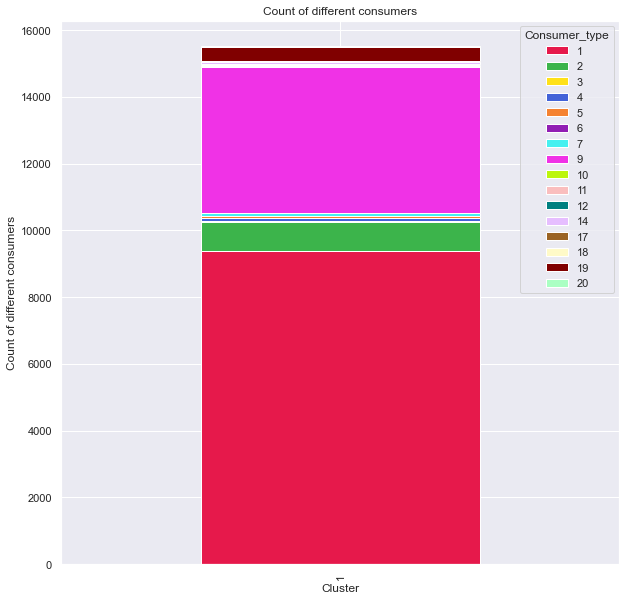

In [250]:
resultDf_1.plot(figsize=(10,10), kind='bar', stacked=True, color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                                               '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', 
                                               '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different consumers')
 
# title of plot
plt.title('Count of different consumers')

Text(0.5, 1.0, 'Count of different consumers')

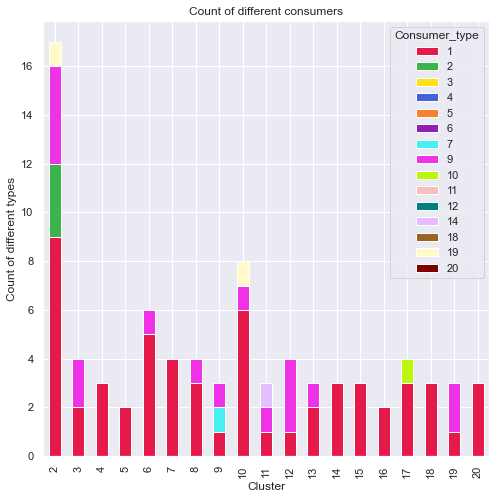

In [251]:
resultDf_2 = resultDf_pivot.drop(index=[1])
df_pivot2.plot(figsize=(8,8), kind='bar', stacked=True, color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                                               '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', 
                                               '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different types')
 
# title of plot
plt.title('Count of different consumers')